In [193]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = False
import random
import csv
import pandas as pd
import h5py
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize 
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
from collections import OrderedDict
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

See the NNC2Pv0 notebook, which was written in the first semester, for some background information. Here, we load the .py scripts which implement the methods etc written in that notebook in an organized manner.

# Own architectures

In [30]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], 
                 reg: bool = False, activation_function = torch.nn.Sigmoid, output_bias=True) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            # For the final layer, do/do not use a bias term (user choice)
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=output_bias))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """

        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

In [31]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["D", "S", "tau"]
out_vars = ["p"]
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_train_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_test_data.csv"))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.fit_transform 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

In [32]:
train_df

,rho,eps,v,p,D,S,tau
0,0.662984,0.084146,0.218802,0.037192,0.679448,0.173724,0.077335
1,8.565808,0.205945,0.657351,1.176059,11.366755,13.318537,7.718100
2,4.387112,1.598809,0.021593,4.676103,4.388135,0.347321,7.020631
3,5.337054,0.530803,0.351307,1.888615,5.700396,4.031171,3.885760
4,1.133895,0.786717,0.079475,0.594703,1.137493,0.209600,0.905115
...,...,...,...,...,...,...,...
79995,8.101834,0.428605,0.616897,2.314990,10.294002,13.832316,9.813427
79996,7.841014,1.125480,0.209087,5.883268,8.018242,4.930289,9.678536
79997,4.628822,0.194190,0.237759,0.599248,4.765476,1.544018,1.129323
79998,9.913117,1.152242,0.477216,7.614874,11.280468,17.889657,18.592193


# Training the network

In [42]:
model = Net(h=[600, 200])
device = "cpu"
model

Net(
  (linear1): Linear(in_features=3, out_features=600, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=600, out_features=200, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=200, out_features=1, bias=True)
)

In [43]:
model_dict = torch.load("NNC2P_new.pth")
# Check whether the model we defined has output bias or not. No bias, then pop this param from dict
if model.linear3.bias == None:
    model_dict.pop('linear3.bias', None)
    print(model_dict.keys())
# Load the model    
model.load_state_dict(model_dict)

<All keys matched successfully>

Getting ready to train:

In [46]:
# Save hyperparameters, loss function and optimizer for training (see paper for details)
learning_rate = 1e-5
batch_size = 32
# NEW - trying out some physics-inspired loss!
# loss_fn = nnc2p.c2p_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train

In [47]:
trainer = nnc2p.Trainer(model, learning_rate)

In [48]:
# trainer.train()

Save the neural network/state dict:

In [19]:
# torch.save(new, 'Models/NNC2P_new_loss.pth')

In [20]:
# torch.save(model.state_dict(), 'Models/NNC2Pv0t2_state_dict.pth')

# Analyzing neural networks

## Plot the losses during training

In [1]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(trainer.train_losses, 'o--', color = 'red', label = 'Train set', lw = lw, ms = ms)
plt.plot(trainer.test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 50
xt = [i*xt_step for i in range(len(train_losses)//xt_step+2)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Loss")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t+200, linestyle = "--", color = 'black', alpha = 0.5, lw = 1)
plt.yscale('log')
# plt.ylim(10**(-9))
# plt.savefig("Plots/test.pdf", bbox_inches = 'tight')
plt.show()

## Estimate the performance of the network

__New version:__ TODO

__Old version:__

In [49]:
# Get features and labels
test_features = nnc2p.TEST_DATA.features
test_labels = nnc2p.TEST_DATA.labels
test_features[:4]

tensor([[10.2041, 12.0266, 22.1313],
        [ 7.0046, 22.3374, 21.0772],
        [ 9.5747, 10.5188, 10.0152],
        [ 0.7725,  1.8519,  1.8100]])

In [50]:
test_features[0]

tensor([10.2041, 12.0266, 22.1313])

In [51]:
# Get predictions
with torch.no_grad():
    p_hat= np.array([])
    for input_values in test_features:
        prediction = model(input_values)
        p_hat = np.append(p_hat, prediction[0].item())

In [52]:
# Get labels as np arrays
p = np.array([])
for value in test_labels:
    p = np.append(p, value[0].item())

In [53]:
# Get the errors:
delta_p_L1 = nnc2p.l1_norm(p_hat, p)
delta_p_Linfty = nnc2p.linfty_norm(p_hat, p)

In [54]:
print("Errors for p: %e  with L1 and %e with Linfty" % (delta_p_L1, delta_p_Linfty) )

Errors for p: 2.623259e-04  with L1 and 8.344986e-03 with Linfty


# Physics inspired neural networks

Here, we try to incorporate some of the physics into the knowledge of the network, more specifically in the training.

## C2C chain (C2P $\circ$ P2C )

In [208]:
test_cons  = nnc2p.TEST_DATA.features[0]
test_press = nnc2p.TEST_DATA.labels[0]
print(test_cons)
print(test_press.item())

tensor([10.2041, 12.0266, 22.1313])
12.866164207458496


In [231]:
# Get og prim values
og_rho = test_df.loc[0].rho
og_eps = test_df.loc[0].eps
print(og_rho)
print(og_eps)

# Testing C2C single example
test_cons = nnc2p.TEST_DATA.features[0]
D_test, S_test, tau_test = test_cons[0].item(), test_cons[1].item(), test_cons[2].item()
print(test_cons)
with torch.no_grad():
    press = model(test_cons.double()).item()
print("p:   ", press)
v_value, W_value, eps_value, rho_value = physics.get_prims(D_test, S_test, tau_test, p=press)
print(f"rho: {rho_value}, original: {og_rho}, difference: {abs(rho_value - og_rho)}")
print(f"eps: {eps_value}, original: {og_eps}, difference: {abs(eps_value - og_eps)}")
d, s, t = physics.p2c(rho_value, eps_value, v_value, press)
print(f"D_test: {D_test}, after C2C: {d}: difference {abs(D_test - d)}")
print(f"S_test: {S_test}, after C2C: {s}: difference {abs(S_test - s)}")

9.83632270803203
1.962038705851822
tensor([10.2041, 12.0266, 22.1313])
p:    12.866371377851234
rho: 9.836326129470775, og: 9.83632270803203, difference: 3.421438744766192e-06
eps: 1.9620390946172184, og: 1.962038705851822, difference: 3.887653963197124e-07
D_test: 10.204131126403809, after C2C: 10.204131126403809: difference 0.0
S_test: 12.02658462524414, after C2C: 12.02658462524414: difference 0.0


In [230]:
test_cons = nnc2p.TEST_DATA.features[0]
D_test, S_test, tau_test = test_cons[0].item(), test_cons[1].item(), test_cons[2].item()
D_new, S_new, tau_new = physics.c2c(D_test, S_test, tau_test, model, nb_repetitions=100)
# print(D_test, S_test, tau_test)
# print(D_new, S_new, tau_new)
print(abs(np.array([D_test, S_test, tau_test]) - np.array([D_new, S_new, tau_new])))

[0. 0. 0.]


Loop over a whole datasets:

In [86]:
l1_error, l2_error = physics.c2c_dataset(nnc2p.TEST_DATA, model)
mse_error = np.mean(l2_error)

In [98]:
# Loop
mse_errors = []
reps = np.arange(1, 21, 2)
for nb_repetitions in reps:
    l1_error, l2_error = physics.c2c_dataset(nnc2p.TEST_DATA, model, nb_repetitions=nb_repetitions)
    mse_error = np.mean(l2_error)
    mse_errors.append(mse_error)

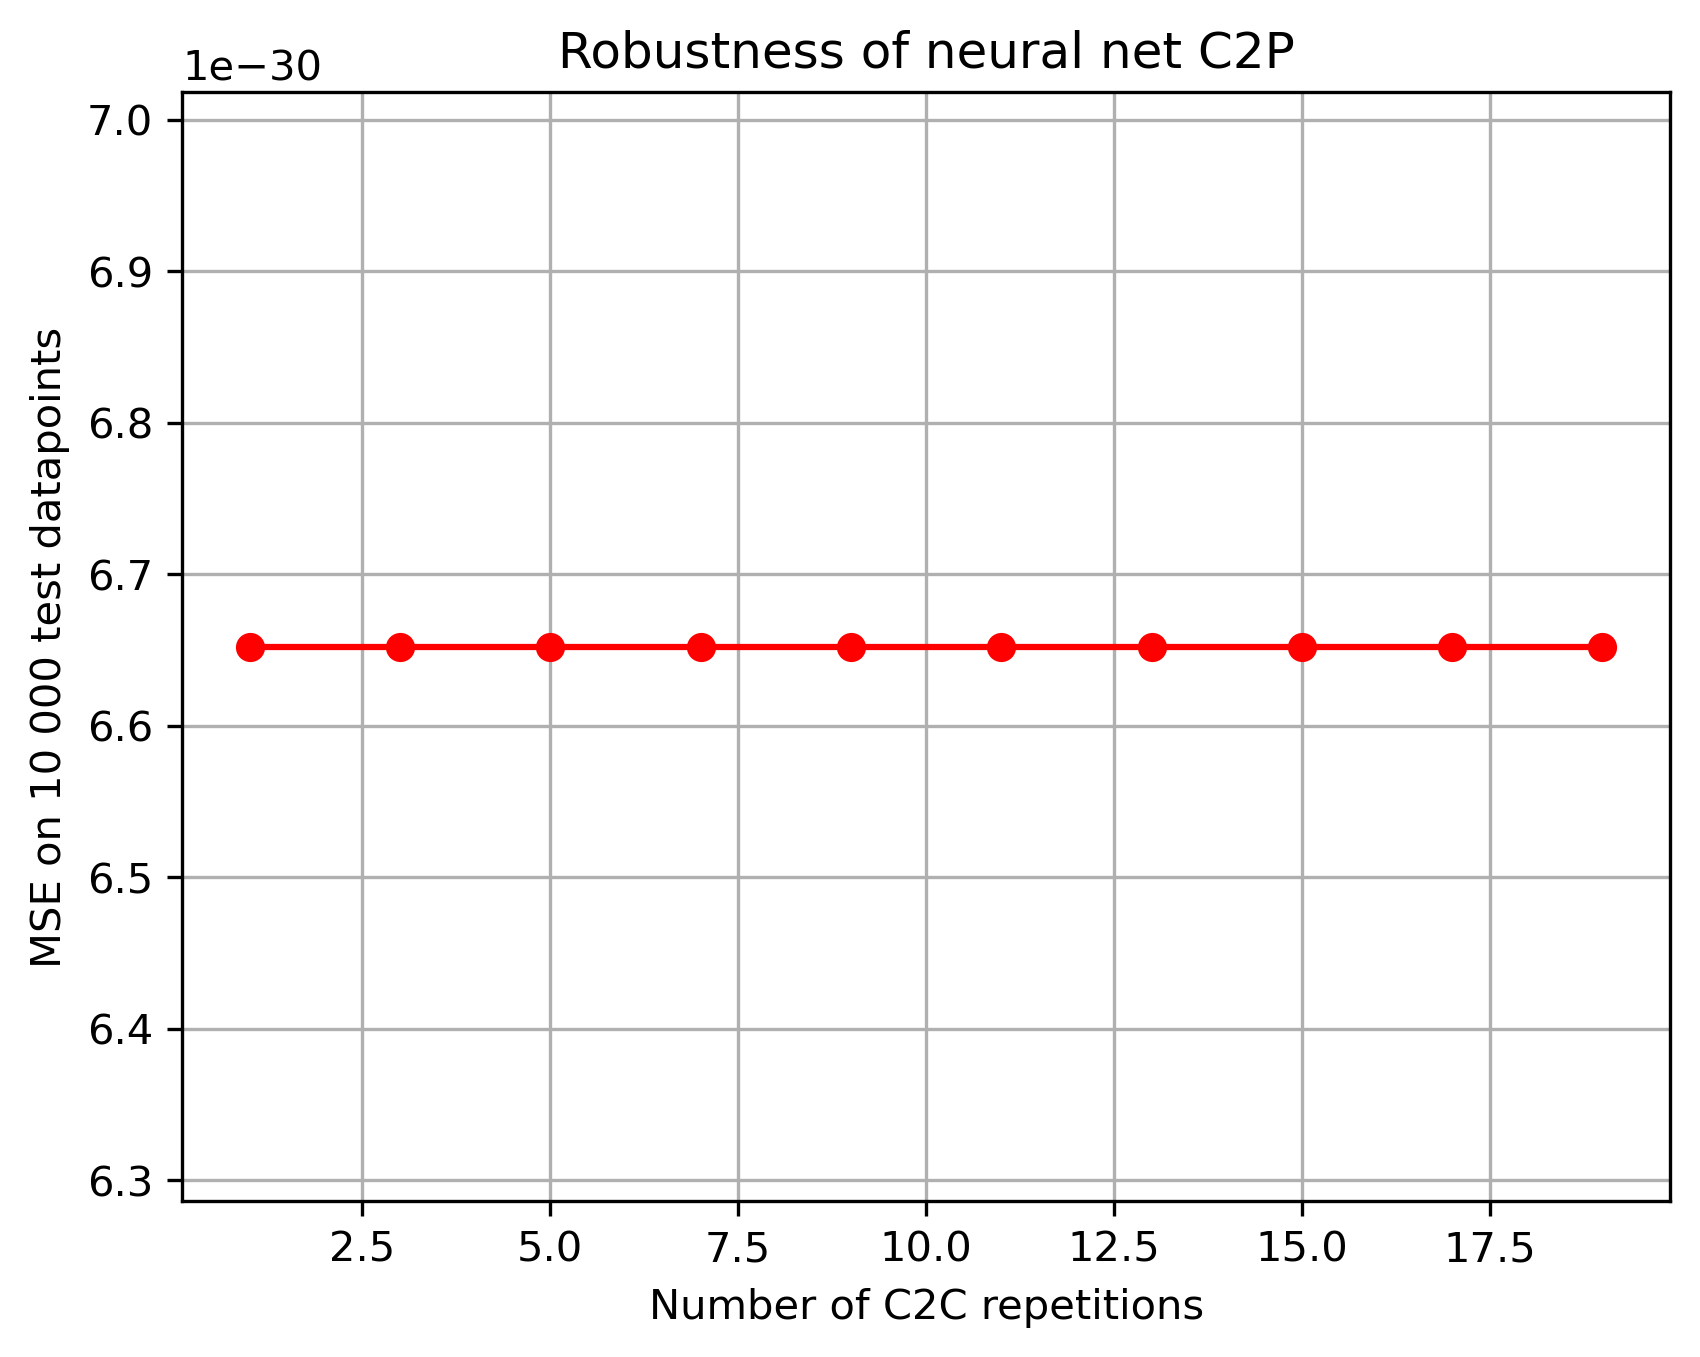

In [ ]:
plt.plot(reps, mse_errors, '-o', color='red')
plt.xlabel("Number of C2C repetitions")
plt.ylabel("MSE on 10 000 test datapoints")
plt.title("Robustness of neural net C2P")
plt.grid()
plt.show()

## P2P chain

In [206]:
# Devise rho and eps vals, fix v, choose different v for different plots
n_rho = 200
n_eps = 200
rho_min, rho_max = 0.05, 10
eps_min, eps_max = 0.01, 2
rho_vals = np.linspace(rho_min, rho_max, n_rho)
eps_vals = np.linspace(eps_min, eps_max, n_eps)
delta_vals = np.zeros((n_eps, n_rho))

Investigate several values for velocity:

__TODO__ fix the plot: the labels and the tick ranges. Adjust the colorbar range properly. Note: for 200 points each direction, takes quite long to plot (1m30s). 

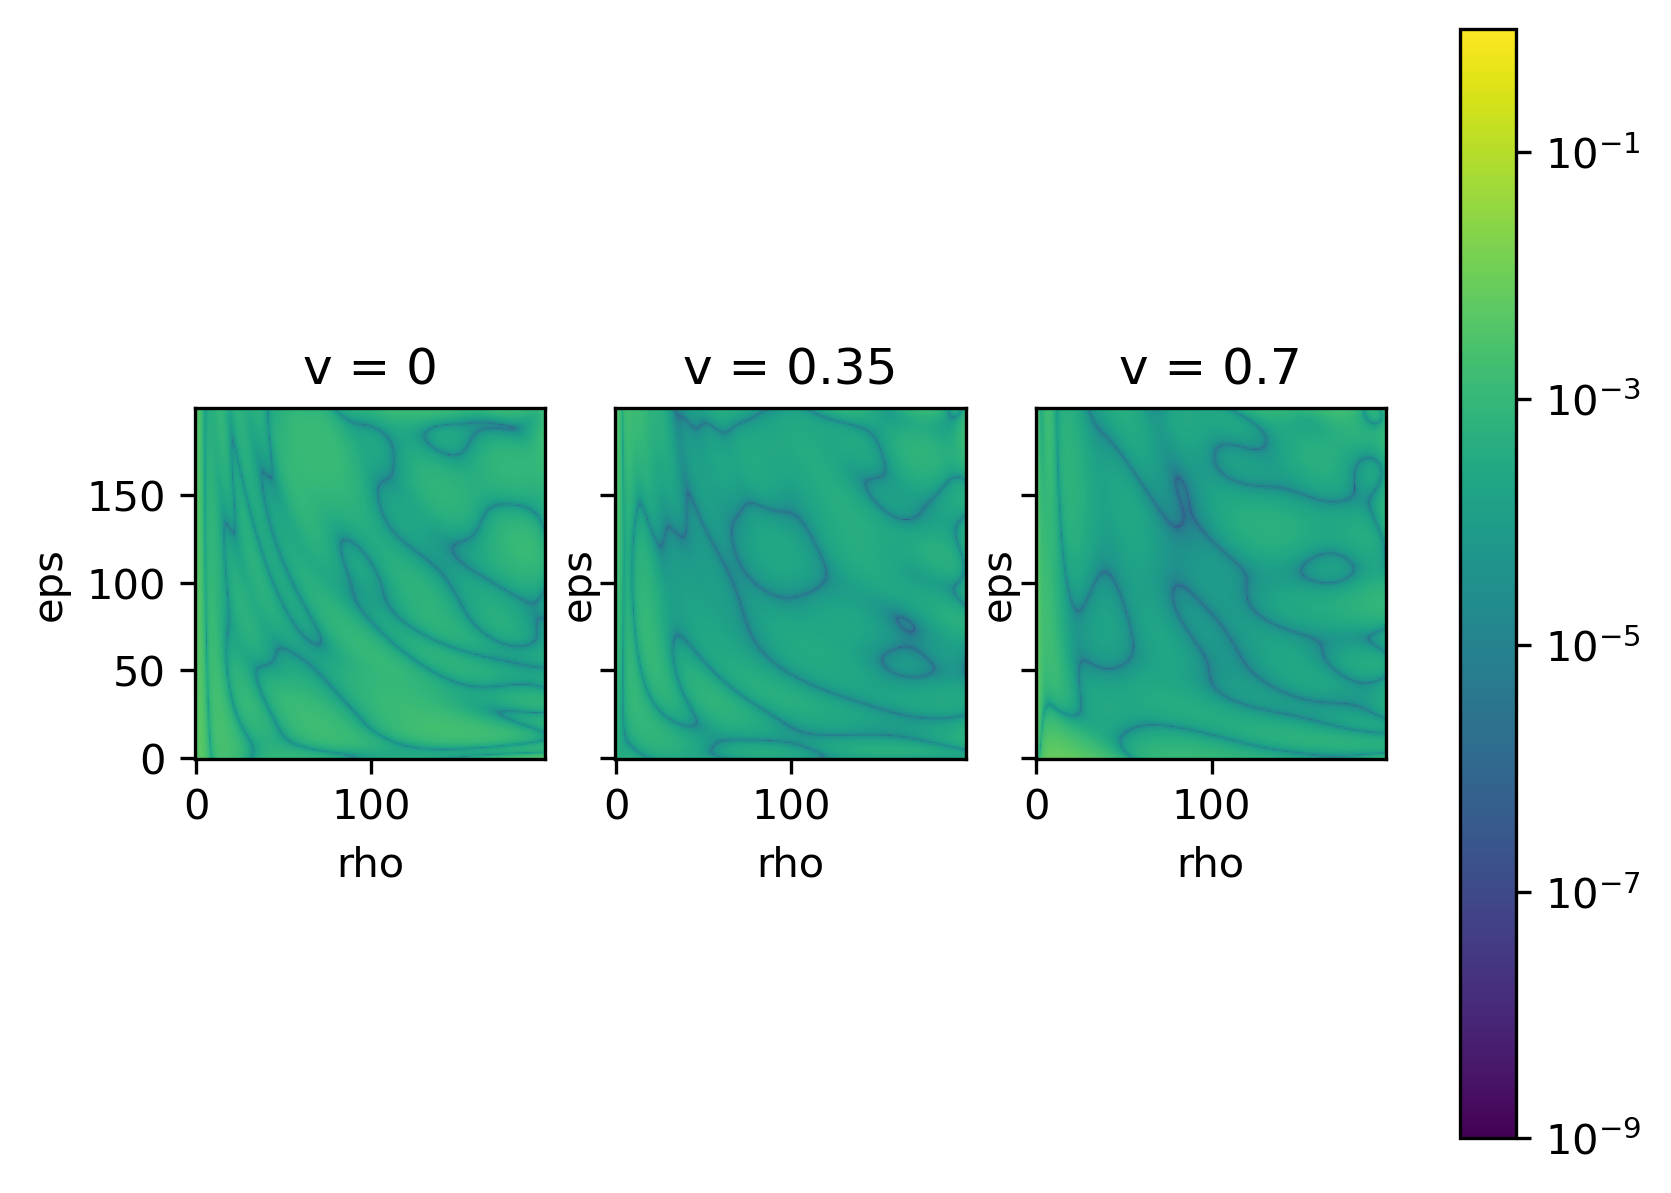

In [207]:
v_list = [0, 0.35, 0.7]
fig, axs = plt.subplots(1, len(v_list), sharey=True)

for i, ax in enumerate(axs):
    # Initialize v and zero the matrix
    v = v_list[i]
    delta_vals = np.zeros((n_eps, n_rho))
    # Get the matrix to plot later on
    for a, eps in enumerate(eps_vals):
        for b, rho in enumerate(rho_vals):
            # Get exact pressure
            p_exact = physics.ideal_eos(rho, eps)
            # Get the pressure
            p_pred = physics.p2p(rho, eps, v, model)
            delta_vals[a][b] = abs(p_exact - p_pred)
    # Then plot it
    im = ax.imshow(delta_vals, origin="lower", norm=LogNorm(vmin=1e-9, vmax=1e0))
    ax.set_xlabel("rho")
    ax.set_ylabel("eps")
    ax.set_title(f"v = {v}")
fig.colorbar(im, ax=axs)
plt.savefig(os.path.join(master_dir, "Plots/recovery_delta_p_plot.pdf"), bbox_inches='tight')
plt.show()

Investigate several loops

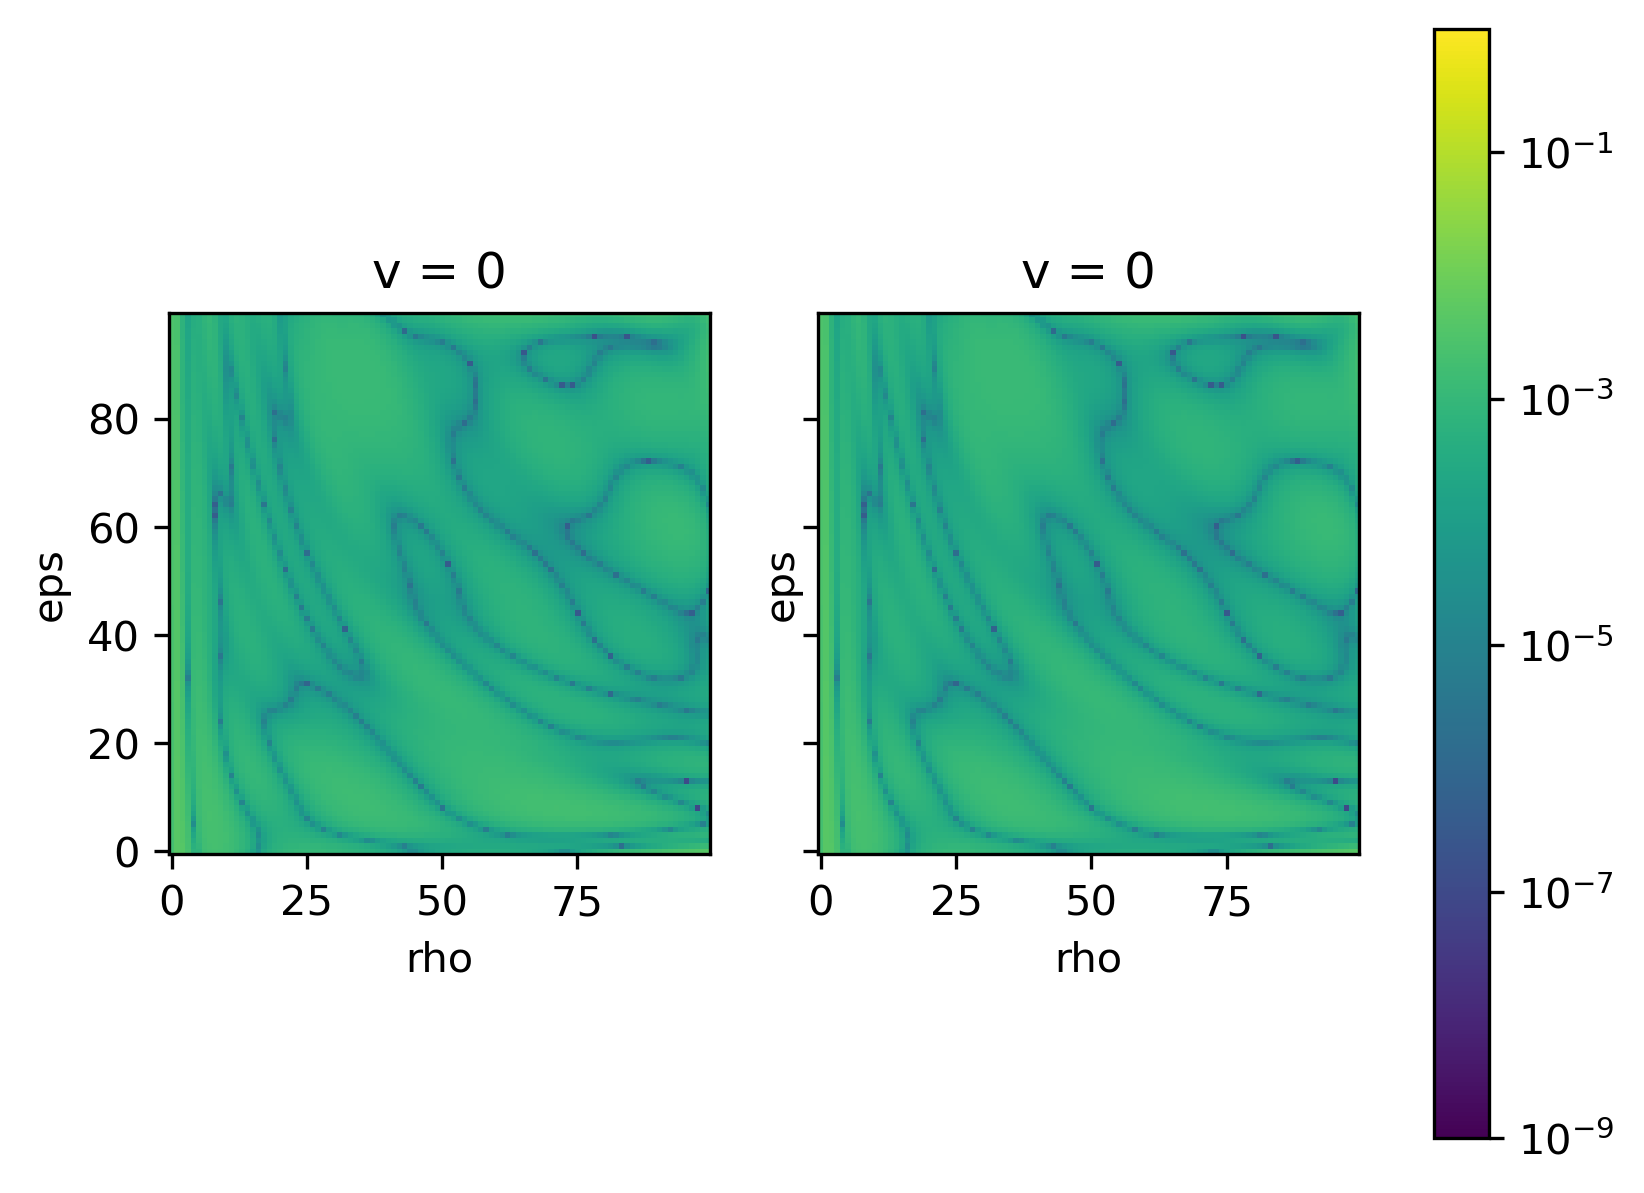

In [204]:
v = 0
nb_repetitions_list = [1, 10]

fig, axs = plt.subplots(1, len(nb_repetitions_list), sharey=True)

for i, ax in enumerate(axs):
    # Initialize v and zero the matrix
    nb_repetitions = nb_repetitions_list[i]
    delta_vals = np.zeros((n_eps, n_rho))
    # Get the matrix to plot later on
    for a, eps in enumerate(eps_vals):
        for b, rho in enumerate(rho_vals):
            # Get exact pressure
            p_exact = physics.ideal_eos(rho, eps)
            # Get the pressure
            p_pred = physics.p2p(rho, eps, v, model, nb_repetitions=nb_repetitions)
            delta_vals[a][b] = abs(p_exact - p_pred)
    # Then plot it
    im = ax.imshow(delta_vals, origin="lower", norm=LogNorm(vmin=1e-9, vmax=1e0))
    ax.set_xlabel("rho")
    ax.set_ylabel("eps")
    ax.set_title(f"v = {v}")
fig.colorbar(im, ax=axs)
plt.show()

# Performance on untrained cases:

__NOTE__ This is a very old piece of code. The goal here was to see how the network performs if we give it examples out of the ranges of its training data. 

Here, we check the performance whenever we use the model on values on which it wasn't trained. Is there a large error compared to the case of seen data?

## When only one parameter gets outside of its range

In [104]:
# We are going to save the performance according to the ranges specified:
# this dict is filled with the errors we found above
errors_dict = {
    "rho max": [rho_max],
    "eps max":[eps_max],
    "v max":[v_max],
    "L1":[delta_p_L1],
    "Linfty":[delta_p_Linfty]}

# Get the parameters we are going to test

# This is how we are going to increment the upper bound each run
delta_rho = 0.01
delta_eps = 0.01
delta_v     = 0.001

number_of_runs = 100

# Construct the parameters
rho_list = [[rho_max + i*delta_rho, eps_max, v_max] for i in range(1, number_of_runs)]
eps_list = [[rho_max, eps_max + i*delta_eps, v_max] for i in range(1, number_of_runs)]
v_list = [[rho_max, eps_max, v_max + i*delta_v] for i in range(1, number_of_runs)]

parameters_list = rho_list + eps_list + v_list 

In [105]:
number_of_datapoints = 10000

p = []
phat = []

with torch.no_grad():
    # Iterate over all parameter bounds
    for [rho_bound, eps_bound, v_bound] in parameters_list:
        # Save current value:
        errors_dict["rho max"].append(rho_bound)
        errors_dict["eps max"].append(eps_bound)
        errors_dict["v max"].append(v_bound)
        
        # Now get 10 000 new cases and predictions
        for i in range(number_of_datapoints):
            
            # Sample randomly from the new range
            rho = random.uniform(rho_min, rho_bound)
            eps = random.uniform(eps_min, eps_bound)
            v     = random.uniform(v_min,           v_bound)
            
            # Get true value
            p.append(eos(rho, eps))

            # Get the prediction
            
            # Compute features (D, S, tau)
            Dvalue    = D(rho, eps, v)
            Svalue     = S(rho, eps, v)
            tauvalue = tau(rho, eps, v)
            
            # Get prediction
            prediction = model(torch.tensor([Dvalue, Svalue, tauvalue]))
            phat.append(prediction[0].item())
            
        # All values computed, store the errors we found
        L1 = L1_norm(np.array(p), np.array(phat))
        errors_dict["L1"].append(L1)
        Linfty= Linfty_norm(np.array(p), np.array(phat))
        errors_dict["Linfty"].append(Linfty)

In [110]:
df = pd.DataFrame(errors_dict)
df

,rho max,eps max,v max,L1,Linfty
0,10.10,2.02,0.721,0.000361,0.008647
1,10.11,2.02,0.721,0.000368,0.008856
2,10.12,2.02,0.721,0.000367,0.010107
3,10.13,2.02,0.721,0.000370,0.010107
4,10.14,2.02,0.721,0.000367,0.010107
...,...,...,...,...,...
293,10.10,2.02,0.816,0.004811,3.184771
294,10.10,2.02,0.817,0.004801,3.184771
295,10.10,2.02,0.818,0.004790,3.184771
296,10.10,2.02,0.819,0.004780,3.184771


In [114]:
sub_df_rho = df.loc[(df["eps max"] == eps_max) & (df["v max"] == v_max)]
sub_df_eps = df.loc[(df["rho max"] == rho_max) & (df["v max"] == v_max)]
sub_df_v = df.loc[(df["rho max"] == rho_max) & (df["eps max"] == eps_max)]

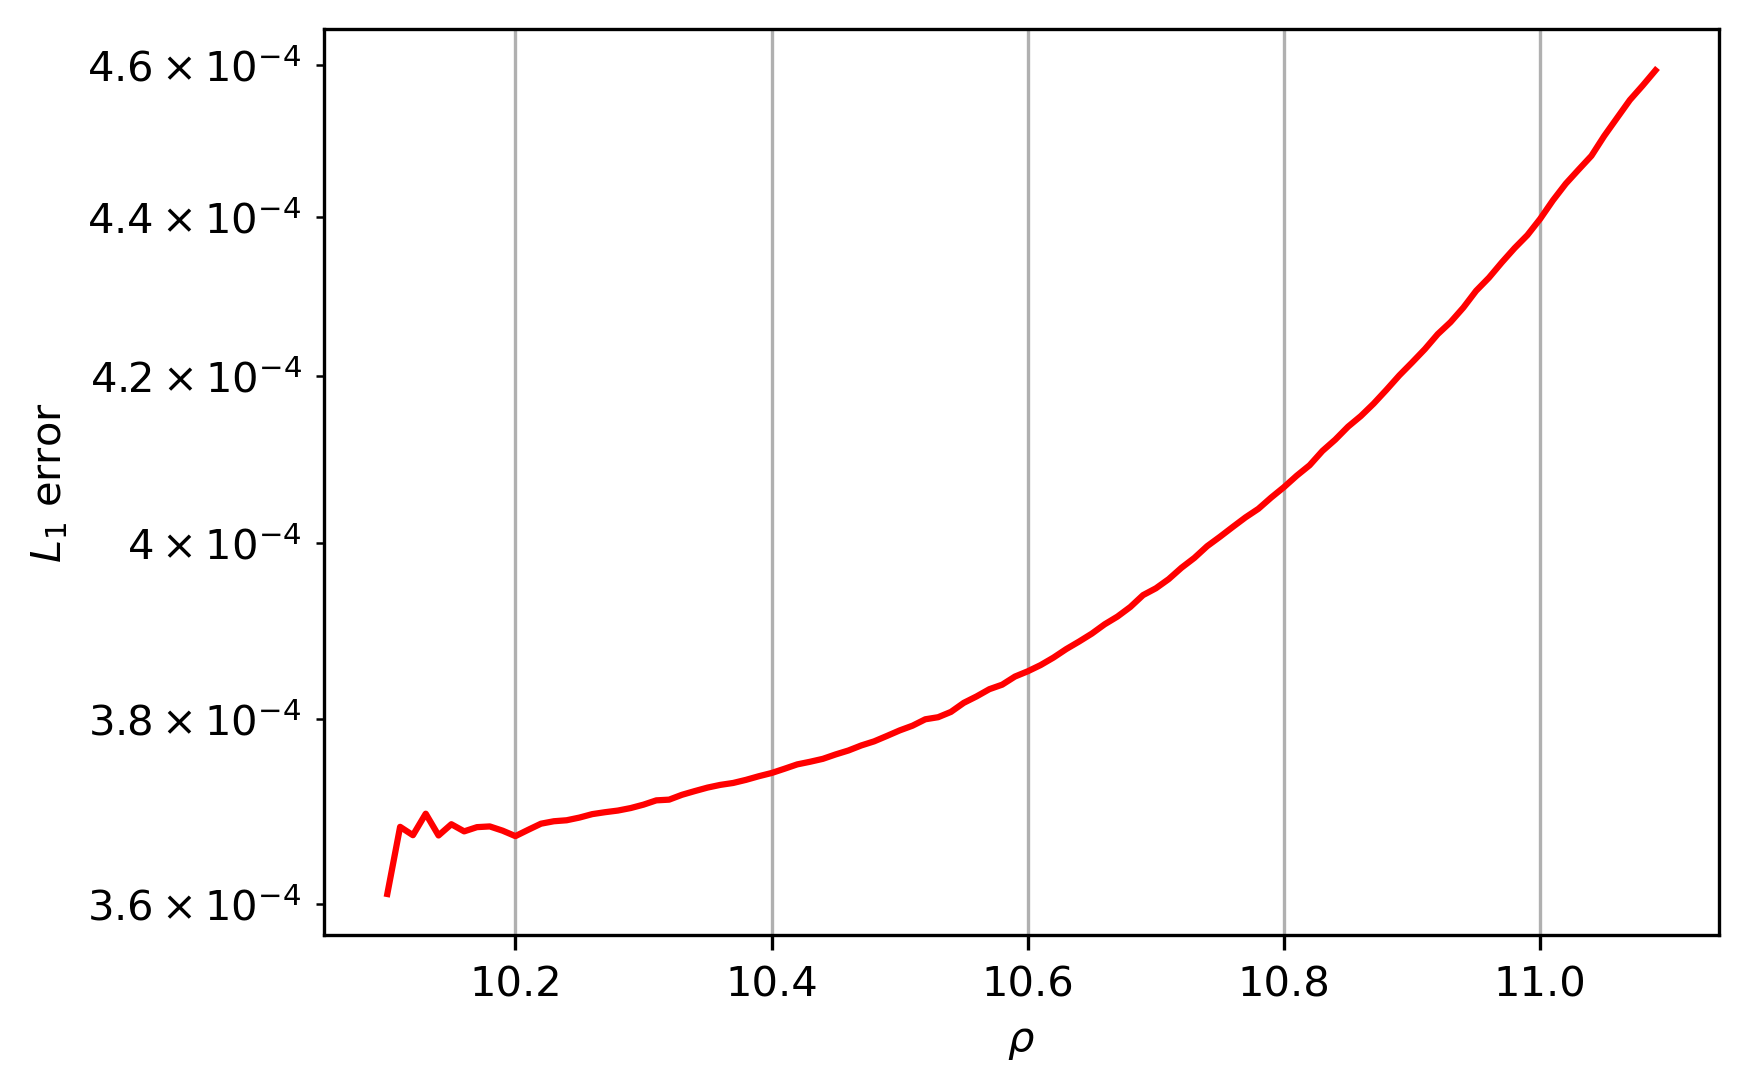

In [119]:
plt.plot(sub_df_rho["rho max"], sub_df_rho["L1"], color='red', label='rho')
# plt.legend()
plt.xlabel(r"$\rho$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.grid()
plt.savefig("error_analysis_v1_rho.pdf", bbox_inches='tight')
plt.show()

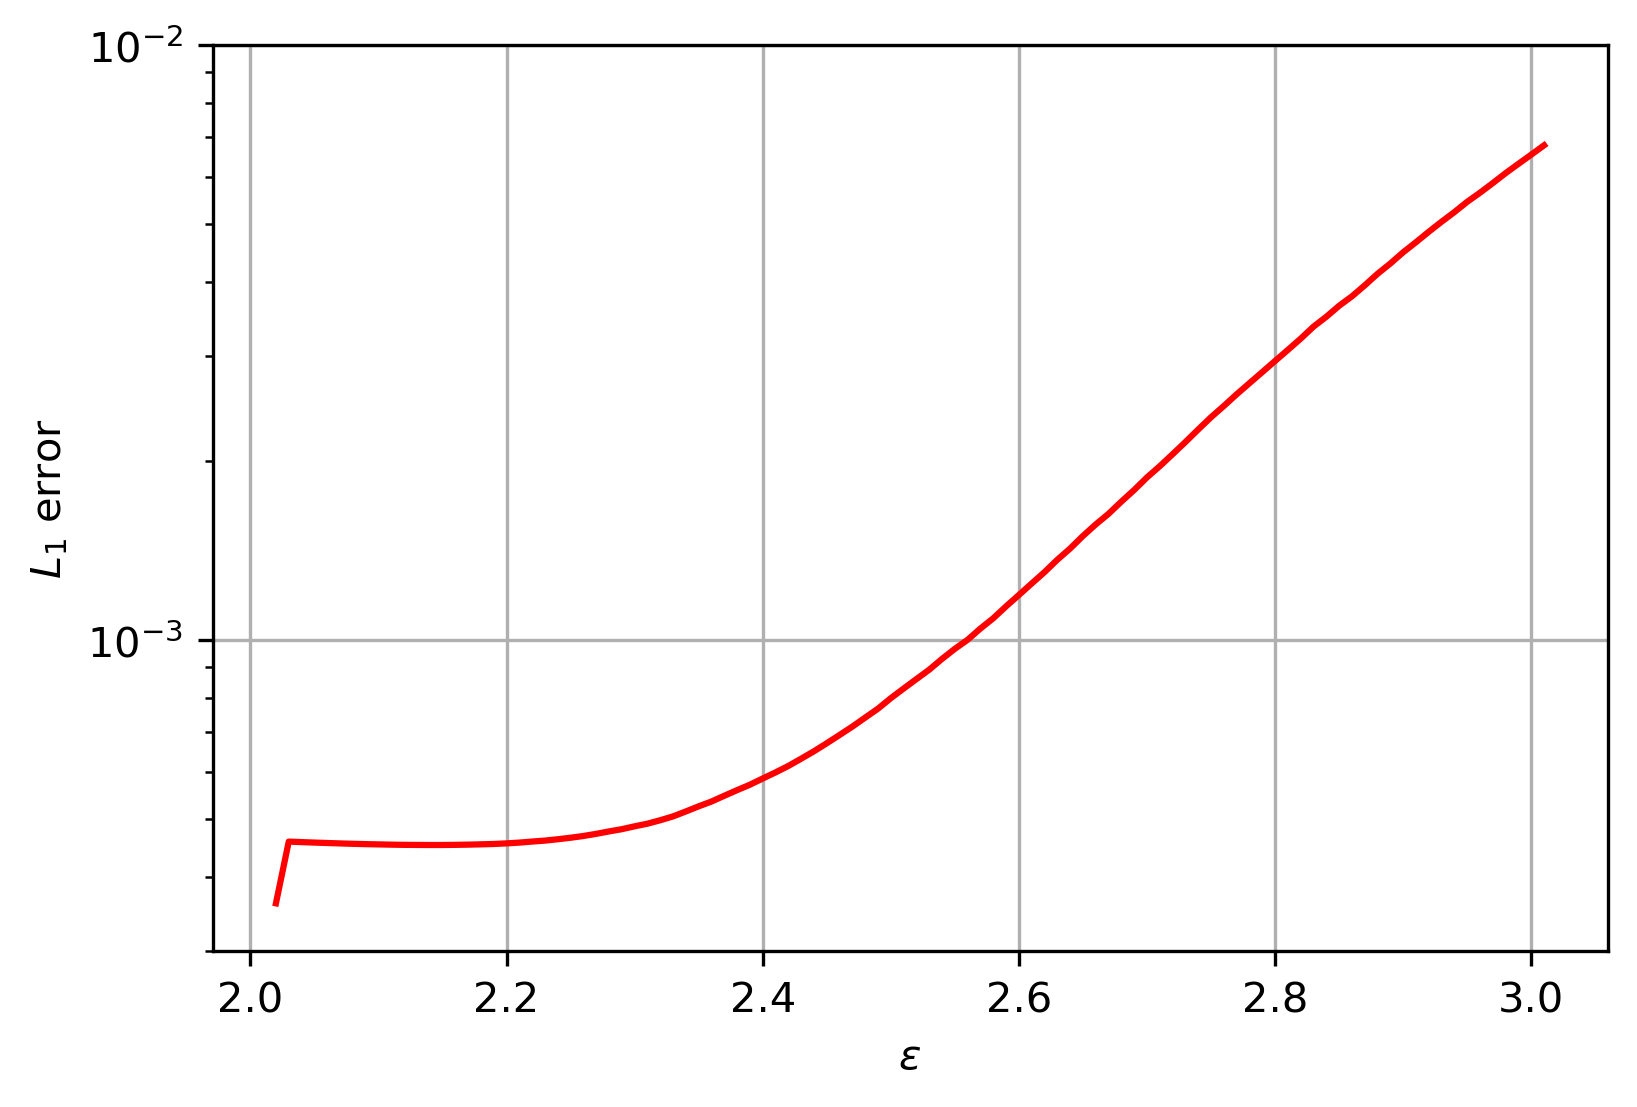

In [130]:
plt.plot(sub_df_eps["eps max"], sub_df_eps["L1"], color='red', label='rho')
# plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.ylim(3*10**(-4), 10**(-2))
plt.grid()
plt.savefig("error_analysis_v1_eps.pdf", bbox_inches='tight')
plt.show()

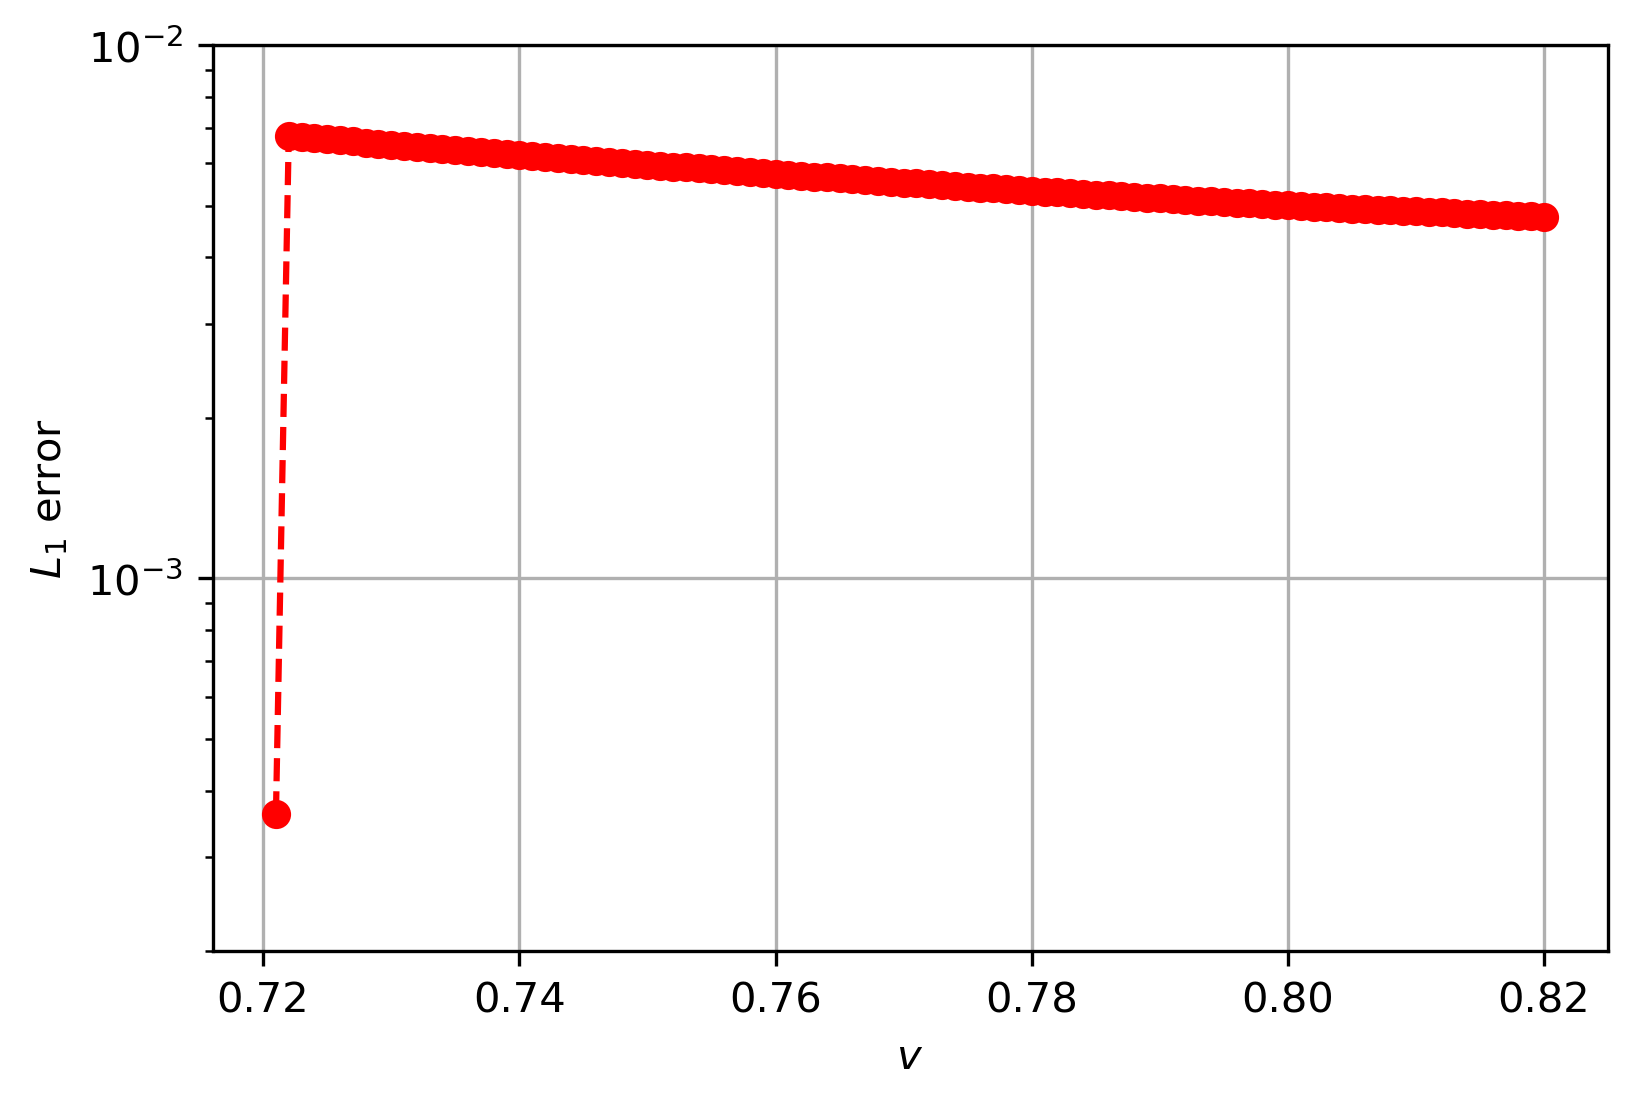

In [129]:
plt.plot(sub_df_v["v max"], sub_df_v["L1"], '--o', color='red', label='rho')
# plt.legend()
plt.xlabel(r"$v$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.ylim(2*10**(-4), 10**(-2))
plt.grid()
plt.savefig("error_analysis_v1_v.pdf", bbox_inches='tight')
plt.show()

Save this data to process later on:

In [107]:
# df.to_csv("Data/errors_analysis_v2.csv")

## When all parameters can go outside of their ranges

In [136]:
# We are going to save the performance according to the ranges specified:
# this dict is filled with the errors we found above
errors_dict = {
    "rho max": [rho_max],
    "eps max":[eps_max],
    "v max":[v_max],
    "L1":[delta_p_L1],
    "Linfty":[delta_p_Linfty]}

# Get the parameters we are going to test

# This is how we are going to increment the upper bound each run
delta_rho = 0.02
delta_eps = 0.02
delta_v     = 0.002

number_of_runs = 10

# Construct the parameters
rho_list = [rho_max + i*delta_rho for i in range(1, number_of_runs)]
eps_list = [eps_max + i*delta_eps for i in range(1, number_of_runs)]
v_list      = [v_max     + i*delta_v for i in range(1, number_of_runs)]

In [138]:
number_of_datapoints = 10000

p = []
phat = []

with torch.no_grad():
    # Iterate over all parameter bounds
    for rho_bound in rho_list:
        for eps_bound in eps_list:
            for v_bound in v_list:
                    # Save current values:
                    errors_dict["rho max"].append(rho_bound)
                    errors_dict["eps max"].append(eps_bound)
                    errors_dict["v max"].append(v_bound)

                    # Now get 10 000 new cases and predictions
                    for i in range(number_of_datapoints):

                        # Sample randomly from the new range
                        rho = random.uniform(rho_min, rho_bound)
                        eps = random.uniform(eps_min, eps_bound)
                        v     = random.uniform(v_min,           v_bound)

                        # Get true value
                        p.append(eos(rho, eps))

                        # Get the prediction

                        # Compute features (D, S, tau)
                        Dvalue    = D(rho, eps, v)
                        Svalue     = S(rho, eps, v)
                        tauvalue = tau(rho, eps, v)

                        # Get prediction
                        prediction = model(torch.tensor([Dvalue, Svalue, tauvalue]))
                        phat.append(prediction[0].item())

                    # All values computed, store the errors we found
                    L1 = L1_norm(np.array(p), np.array(phat))
                    errors_dict["L1"].append(L1)
                    Linfty= Linfty_norm(np.array(p), np.array(phat))
                    errors_dict["Linfty"].append(Linfty)

In [139]:
df = pd.DataFrame(errors_dict)
df

,rho max,eps max,v max,L1,Linfty
0,10.10,2.02,0.721,0.000361,0.008647
1,10.12,2.04,0.723,0.000368,0.009280
2,10.12,2.04,0.725,0.000369,0.009725
3,10.12,2.04,0.727,0.000371,0.009725
4,10.12,2.04,0.729,0.000373,0.009725
...,...,...,...,...,...
725,10.28,2.20,0.731,0.000463,0.135447
726,10.28,2.20,0.733,0.000463,0.135447
727,10.28,2.20,0.735,0.000463,0.135447
728,10.28,2.20,0.737,0.000464,0.135447


In [150]:
sub_df_rho_eps = df.loc[(df["v max"] == v_max) |( df["v max"] == v_max+delta_v)]
sub_df_rho_v = df.loc[(df["eps max"] == eps_max) |( df["eps max"] == eps_max+delta_eps)]
sub_df_eps_v = df.loc[(df["rho max"] == rho_max) |( df["rho max"] == rho_max+delta_rho)]

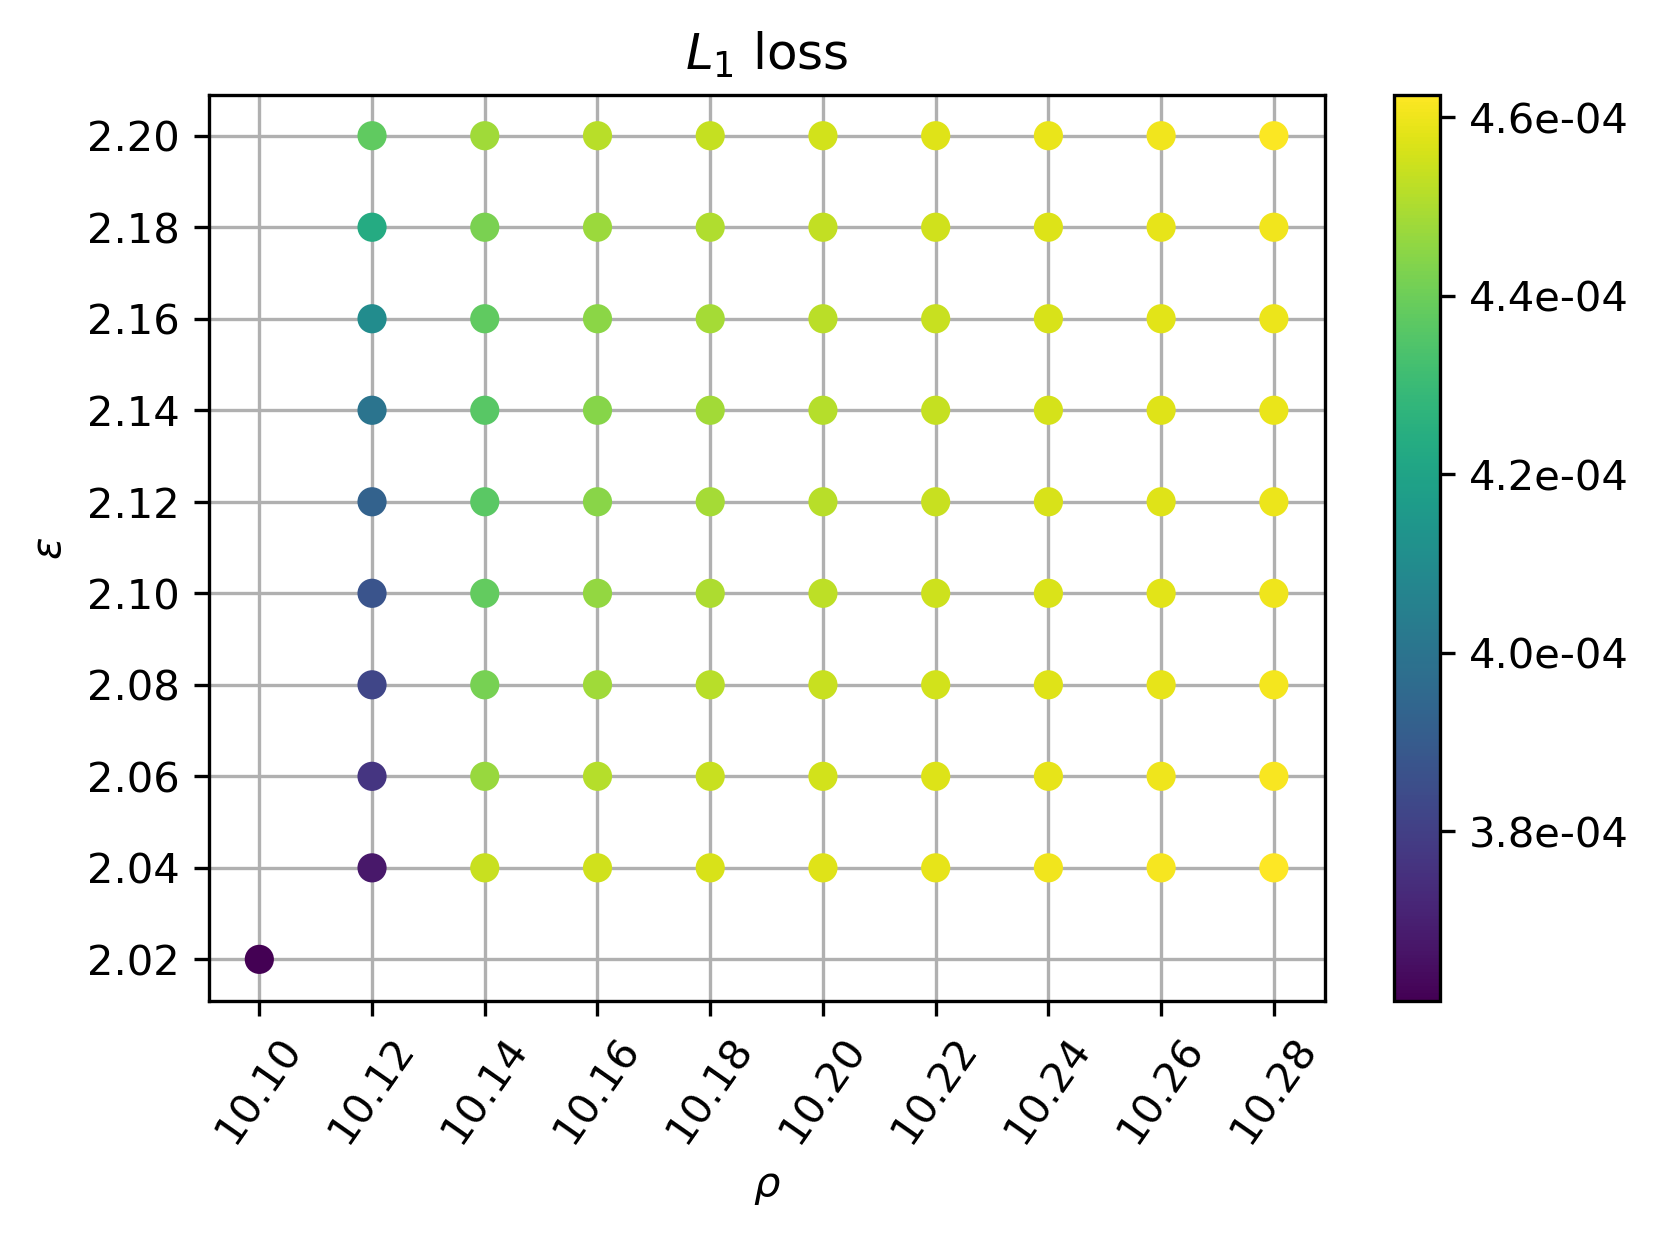

In [178]:
plt.scatter(sub_df_rho_eps["rho max"], sub_df_rho_eps["eps max"], c=sub_df_rho_eps["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\varepsilon$")
plt.xticks(list(set(sub_df_rho_eps["rho max"])), rotation=55)
plt.yticks(list(set(sub_df_rho_eps["eps max"])))
plt.grid()
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_rho_eps.pdf", bbox_inches='tight')
plt.show()

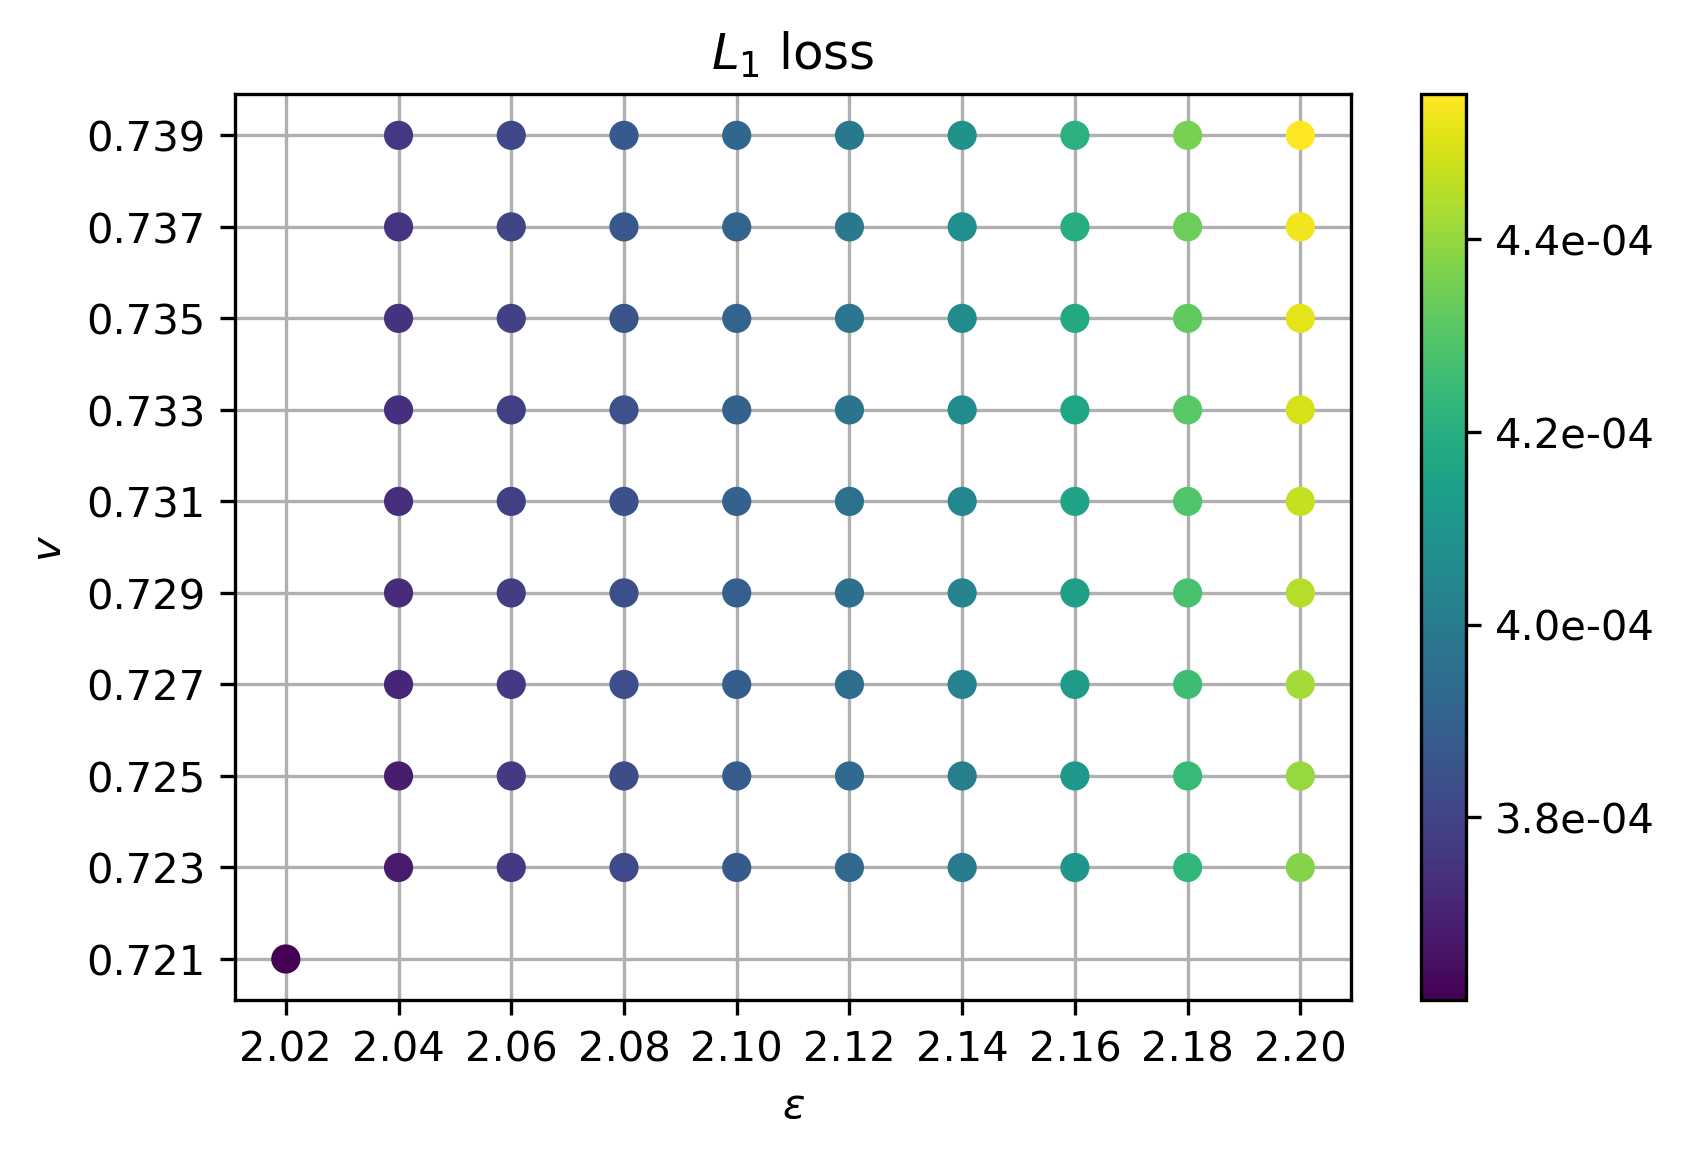

In [180]:
plt.scatter(sub_df_eps_v["eps max"], sub_df_eps_v["v max"], c=sub_df_eps_v["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xticks(list(set(sub_df_eps_v["eps max"])))
plt.yticks(list(set(sub_df_eps_v["v max"])))
plt.grid()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$v$")
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_eps_v.pdf", bbox_inches='tight')
plt.show()

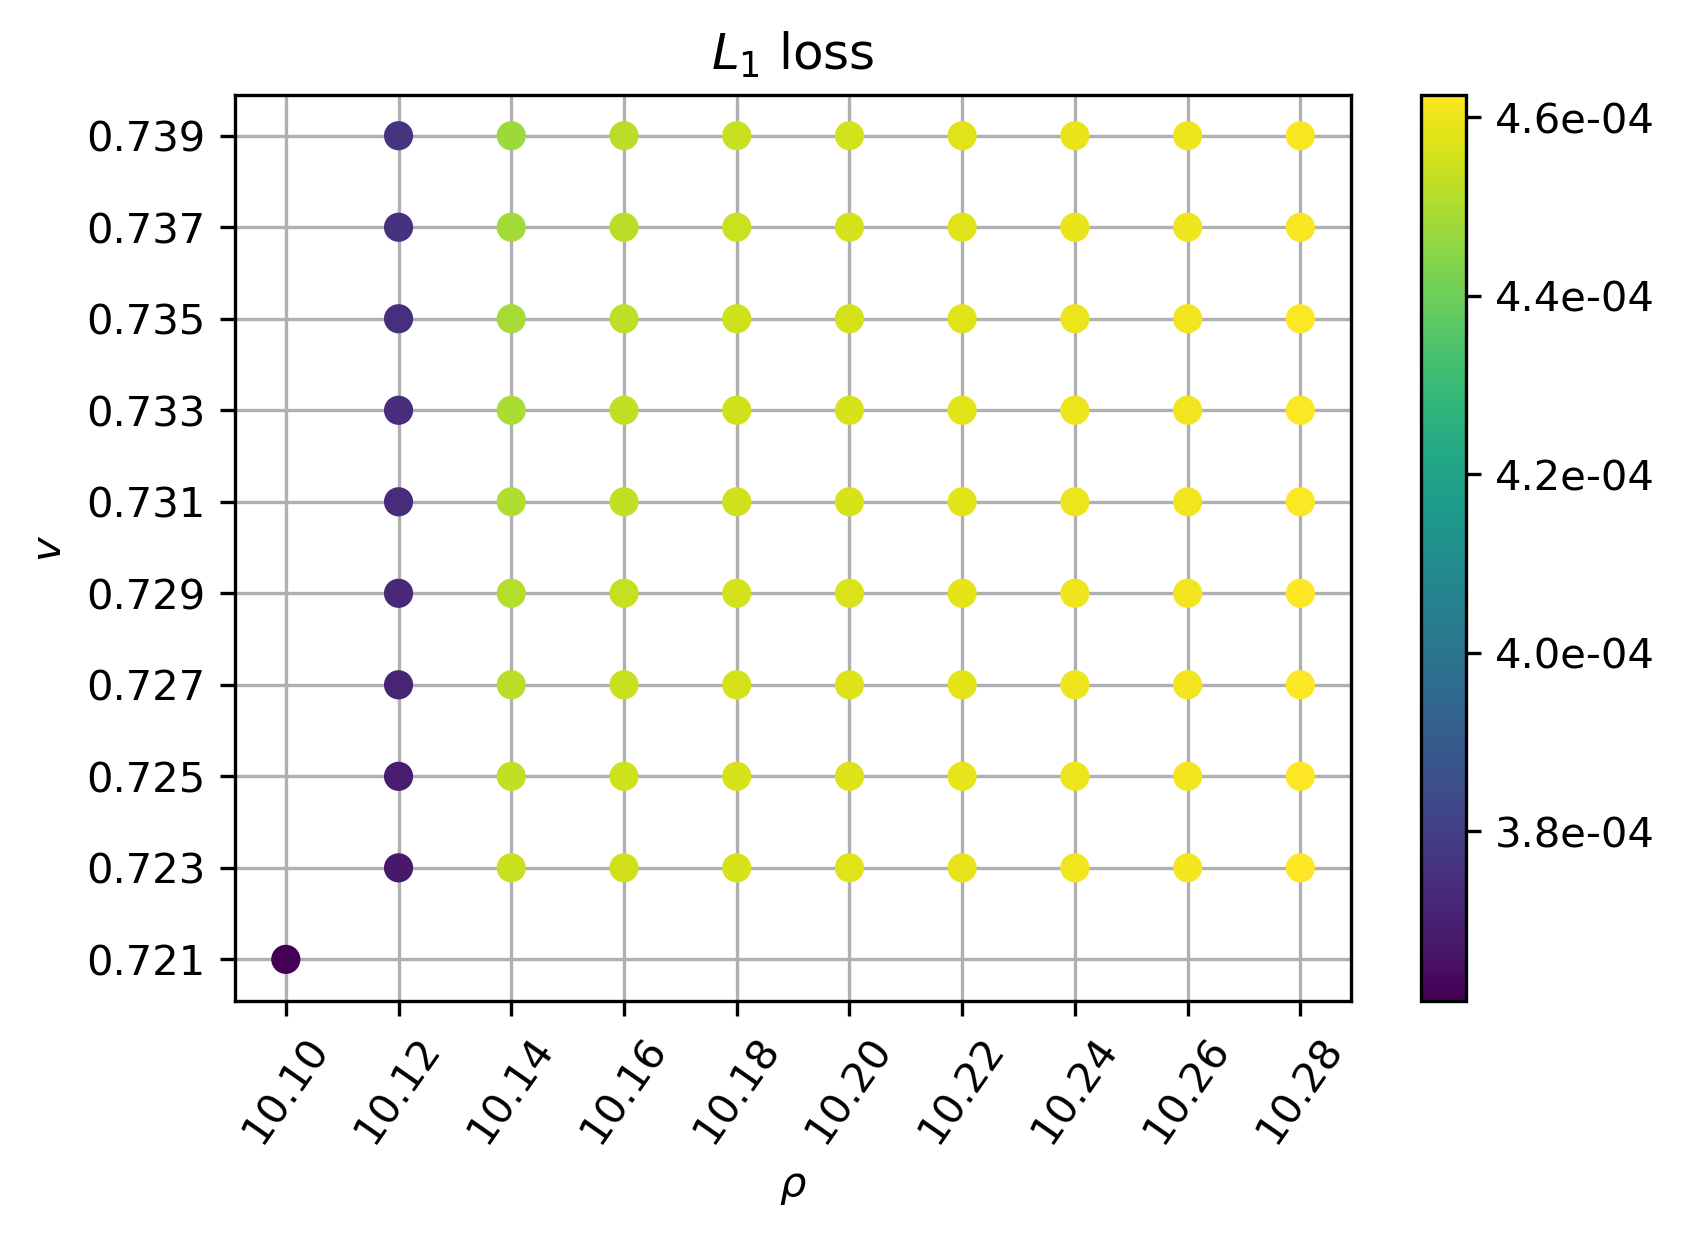

In [184]:
plt.scatter(sub_df_rho_v["rho max"], sub_df_rho_v["v max"], c=sub_df_rho_v["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xlabel(r"$\rho$")
plt.xticks(list(set(sub_df_rho_v["rho max"])), rotation=55)
plt.yticks(list(set(sub_df_rho_v["v max"])))
plt.grid()
plt.ylabel(r"$v$")
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_rho_v.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))

Save this data to process later on:

In [140]:
# df.to_csv("Data/errors_analysis_v2.csv")

# Get parameters of network out:

In [47]:
with torch.no_grad():
    for param in NNC2P.parameters():
        print(param)

Parameter containing:
tensor([[-0.3637,  0.4540, -0.4355],
        [ 0.0066,  0.6949,  0.4879],
        [ 0.1112, -0.0925,  0.1091],
        ...,
        [ 0.5306, -0.4535, -0.3026],
        [-0.4308, -0.1415,  0.2810],
        [ 0.6349, -0.2947,  0.0561]], requires_grad=True)
Parameter containing:
tensor([ 0.5675,  0.2904, -0.7667, -0.3078, -0.1945,  0.0523,  0.0514, -0.4138,
         0.2312, -0.5222,  0.2495, -0.3197, -0.4844, -0.5024, -0.3668, -0.2699,
         0.7860,  0.7489,  0.1024,  0.8798,  0.1536, -0.4353, -0.3389, -0.5969,
        -0.4334, -0.7355, -0.4756, -0.4140, -0.1220, -0.1788, -0.7250, -0.0075,
         0.2842,  0.1193,  0.5405, -0.1805, -0.0228, -0.3408, -0.1134, -0.2822,
         0.5498, -0.1406,  0.3311, -0.5858,  0.0567, -0.2661,  0.3879,  0.8417,
        -0.2426,  0.5311,  0.0035,  0.1361, -0.3355,  0.2191, -0.3657,  0.0739,
        -0.7668, -0.7611, -0.4528,  0.7155,  0.4711,  0.1546, -0.7966, -0.6006,
         0.5338, -0.4438, -0.5507,  0.2647, -0.5531, -0.1843